In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl

sns.set_theme(style="ticks", context="talk")
plt.style.use("dark_background")
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder

from sklearn.model_selection import (StratifiedGroupKFold,
    StratifiedShuffleSplit, cross_val_score, learning_curve, RepeatedStratifiedKFold, GridSearchCV, train_test_split, ShuffleSplit
)
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb


from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, RocCurveDisplay, roc_curve, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (OneHotEncoder, StandardScaler, OrdinalEncoder)

from scipy.stats.mstats import winsorize

import torch
import torch.nn as nn
import torch.optim as optim
import shap


import joblib
import re
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_df = pd.read_csv("train.csv")
test_df  = pd.read_csv("test.csv")

train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

y_train = train["Survived"].copy()
groups  = train["Ticket"].copy()

# train = train.drop(columns="Survived")
train["__is_train"] = 1
test ["__is_train"] = 0

full = pd.concat([train, test], ignore_index=True)

train_mask = full["__is_train"] == 1
test_mask  = full["__is_train"] == 0

In [3]:
print("Train shape:", train.shape)
print("Test shape:",  test.shape)

print("\n=== Missing values (Train) ===")
print(train.isnull().sum())

Train shape: (891, 13)
Test shape: (418, 12)

=== Missing values (Train) ===
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
__is_train       0
dtype: int64


In [4]:
full['Surname'] = full["Name"].str.extract(r"^([^,]+)")

In [5]:
title_map = {
    "Mme":    "Mrs",
    "Mlle":   "Miss",
    "Miss":   "Miss",
    "Ms":     "Mrs",
    "Mrs":     "Mrs",
    "Mr":     "Mr",
    "Capt":   "Captain",
    "Major":  "Officer",
    "Col":    "Officer",      
    "Dr":     "Profession",
    "Rev":    "Profession",
    "Sir":    "Royalty",
    "Lady":   "Royalty",
    "Countess":"Royalty",    
    "Don":    "Royalty",
    "Dona":   "Royalty",
    "Jonkheer":"Royalty",
    "Master": "Boy"
}

In [6]:
for df in (train_df, test_df):
    df['Surname']   = df['Name'].str.split(',').str[0]
    df["Title"] = df["Name"] .str.extract(r" ([A-Za-z]+)\.")[0].map(title_map)
    df['FamilyID']  = df['Surname'] + "_" + df['Pclass'].astype(str)
    df['IsBoy']    = (df['Title']=='Boy').astype(int)
    df['IsFemale'] = (df['Sex']=='female').astype(int)
    


# 2) готовим пустые колонки для train
train_df['Fam_WC_Total']     = 0
train_df['Fam_WC_Survived']  = 0
train_df['FamilyAllWC_Survived'] = False
train_df['FamilyAllWC_Died']     = False

# 3) делаем GroupKFold по FamilyID, чтобы считать в OOF режиме
gkf = GroupKFold(n_splits=5)
for tr_idx, val_idx in gkf.split(train_df, groups=train_df['FamilyID']):
    tr = train_df.iloc[tr_idx]
    val = train_df.iloc[val_idx]

    grp = tr.groupby('FamilyID')
    sums_df     = grp[['IsBoy','IsFemale']].sum()
    total       = sums_df.sum(axis=1)
    survived    = grp.apply(lambda g: ((g['IsBoy']|g['IsFemale']) & (g['Survived']==1)).sum())

    # мапим на валидационные индексы
    train_df.loc[val_idx, 'Fam_WC_Total']    = train_df.loc[val_idx, 'FamilyID'].map(total).fillna(0).astype(int)
    train_df.loc[val_idx, 'Fam_WC_Survived'] = train_df.loc[val_idx, 'FamilyID'].map(survived).fillna(0).astype(int)

# 4) после OOF заполнения считаем финальные булевы фичи
train_df['Fam_WC_Died'] = train_df['Fam_WC_Total'] - train_df['Fam_WC_Survived']
train_df['FamilyAllWC_Survived'] = train_df['Fam_WC_Survived'] == train_df['Fam_WC_Total']
train_df['FamilyAllWC_Died']     = train_df['Fam_WC_Died']     == train_df['Fam_WC_Total']


# 5) теперь аналогично готовим test_df, но уже на всем train
grp_all        = train_df.groupby('FamilyID')
sums_all_df    = grp_all[['IsBoy','IsFemale']].sum()
total_all      = sums_all_df.sum(axis=1)
survived_all   = grp_all.apply(
    lambda g: ((g['IsBoy']|g['IsFemale']) & (g['Survived']==1)).sum()
)
# теперь мапим на test_df
test_df['Fam_WC_Total']    = test_df['FamilyID'].map(total_all).fillna(0).astype(int)
test_df['Fam_WC_Survived'] = test_df['FamilyID'].map(survived_all).fillna(0).astype(int)
test_df['Fam_WC_Died']     = test_df['Fam_WC_Total'] - test_df['Fam_WC_Survived']
test_df['FamilyAllWC_Survived'] = test_df['Fam_WC_Survived'] == test_df['Fam_WC_Total']
test_df['FamilyAllWC_Died']     = test_df['Fam_WC_Died']     == test_df['Fam_WC_Total']


NameError: name 'GroupKFold' is not defined

In [872]:
y_train = train_df["Survived"].copy()
X_train = train_df[['Pclass','IsBoy', 'IsFemale', 'Fam_WC_Total', 'Fam_WC_Survived',
       'FamilyAllWC_Survived', 'FamilyAllWC_Died', 'Fam_WC_Died']]

X_test = test_df[['Pclass','IsBoy', 'IsFemale', 'Fam_WC_Total', 'Fam_WC_Survived',
       'FamilyAllWC_Survived', 'FamilyAllWC_Died', 'Fam_WC_Died']]

In [876]:
X_train

,Pclass,IsBoy,IsFemale,Fam_WC_Total,Fam_WC_Survived,FamilyAllWC_Survived,FamilyAllWC_Died,Fam_WC_Died
0,3,0,0,0,0,True,True,0
1,1,0,1,0,0,True,True,0
2,3,0,1,0,0,True,True,0
3,1,0,1,0,0,True,True,0
4,3,0,0,0,0,True,True,0
...,...,...,...,...,...,...,...,...
886,2,0,0,0,0,True,True,0
887,1,0,1,0,0,True,True,0
888,3,0,1,0,0,True,True,0
889,1,0,0,0,0,True,True,0


In [813]:

# obj_cols    = full.select_dtypes("object").columns
# train_ohe   = pd.get_dummies(full.loc[train_mask, obj_cols], drop_first=True)
# test_ohe    = pd.get_dummies(full.loc[test_mask,  obj_cols], drop_first=True)
# all_ohe_cols= train_ohe.columns.union(test_ohe.columns)
# train_ohe   = train_ohe.reindex(columns=all_ohe_cols, fill_value=0)
# test_ohe    = test_ohe.reindex(columns=all_ohe_cols, fill_value=0)

# num_cols    = full.select_dtypes("number").columns.drop("__is_train")
# train_num   = full.loc[train_mask,   num_cols].reset_index(drop=True)
# test_num    = full.loc[test_mask,    num_cols].reset_index(drop=True)

# X_train     = pd.concat([train_num, train_ohe.reset_index(drop=True)], axis=1)
# X_test      = pd.concat([ test_num,  test_ohe.reset_index(drop=True)], axis=1)

# scaler = StandardScaler()
# X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
# X_test [num_cols] = scaler.transform( X_test [num_cols])

# X_train = X_train.fillna(0)
# X_test  = X_test.fillna(0)


# # ───────────────────────── 4. Итоги ─────────────────────────────────
# print("Train / Test shapes:", X_train.shape, X_test.shape)

Train / Test shapes: (891, 21) (418, 21)


In [873]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
scores = []
for tr_idx, val_idx in cv.split(X_train, y_train):
    rf = RandomForestClassifier(
            n_estimators=5000, 
            random_state=42, n_jobs=-1)
    rf.fit(X_train.iloc[tr_idx], y_train.iloc[tr_idx])
    preds = rf.predict(X_train.iloc[val_idx])
    scores.append(accuracy_score(y_train.iloc[val_idx], preds))

print("ShuffleSplitKFold accuracy:", scores, "mean =", round(np.mean(scores),4))

ShuffleSplitKFold accuracy: [0.7835820895522388, 0.8097014925373134, 0.8059701492537313, 0.7686567164179104, 0.8134328358208955] mean = 0.7963


              precision    recall  f1-score   support

           0       0.76      0.98      0.86       549
           1       0.95      0.51      0.66       342

    accuracy                           0.80       891
   macro avg       0.86      0.74      0.76       891
weighted avg       0.83      0.80      0.78       891

ROC AUC: 0.8619


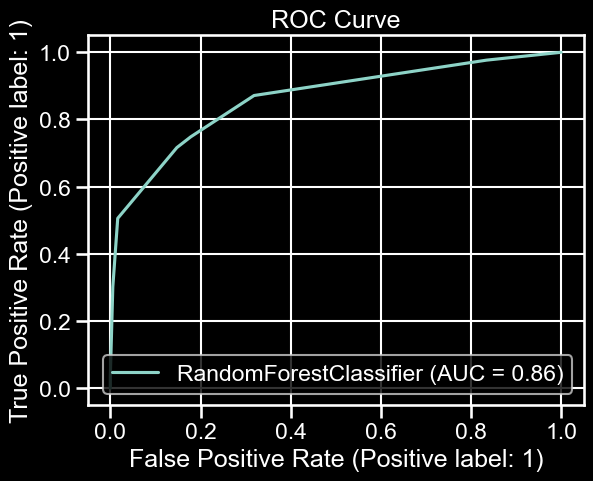

In [874]:
rf = RandomForestClassifier(
        n_estimators=5000, 
        random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_train)
y_proba = rf.predict_proba(X_train)[:, 1]

print(classification_report(y_train, y_pred))

roc_auc = roc_auc_score(y_train, y_proba)
print(f"ROC AUC: {roc_auc:.4f}")

RocCurveDisplay.from_estimator(rf, X_train, y_train)
plt.title("ROC Curve")
plt.grid(True)
plt.show()

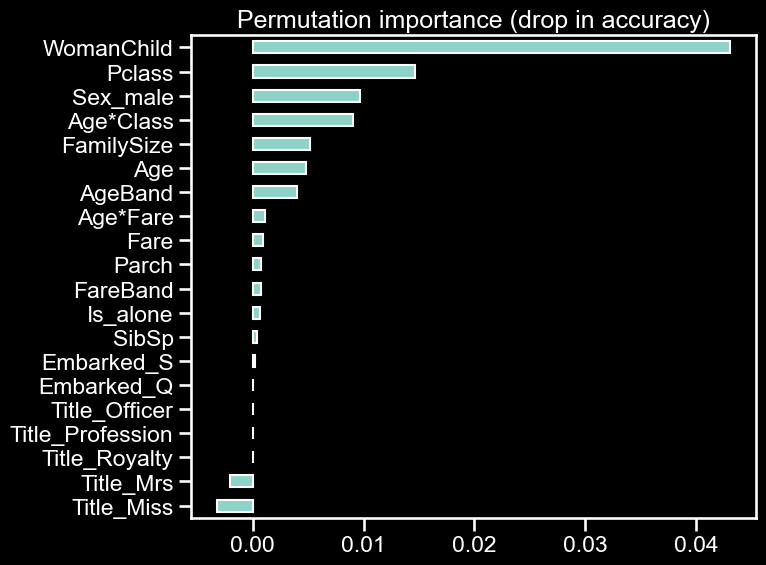

In [828]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
            rf_beast, X_train, y_train,
            n_repeats=50, scoring="accuracy", random_state=42, n_jobs=-1)

perm_imp = pd.Series(result.importances_mean, index=X_train.columns) \
              .sort_values(ascending=False)

perm_imp.plot.barh(figsize=(8,6))
plt.gca().invert_yaxis()
plt.title("Permutation importance (drop in accuracy)")
plt.tight_layout(); plt.show()


In [801]:
submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": rf.predict(X_test)
})
submission.to_csv("rf_submission.csv", index=False)

In [783]:
X_train.columns.symmetric_difference(X_test.columns)

Index([], dtype='object')

In [784]:
X_test.isna().sum().sum()

0

In [446]:
import optuna

In [825]:
def objective(trial):
    params = {
        "n_estimators":     trial.suggest_int( "n_estimators",     500, 5000, step=100),
        "max_depth":        trial.suggest_int( "max_depth",        3,   10),           
        "min_samples_split":trial.suggest_int( "min_samples_split",2,   10),
        "min_samples_leaf": trial.suggest_int( "min_samples_leaf", 1,   10),
        "max_features":     trial.suggest_categorical("max_features",
                                 ["sqrt", "log2", None, 0.5, 0.8]),
        "bootstrap":        trial.suggest_categorical("bootstrap", [True, False]),
        "random_state":     42,
        "n_jobs":           -1
    }

    rf = RandomForestClassifier(**params)
    score = cross_val_score(rf,
                            X_train, y_train,              # ← ваши данные
                            cv=cv,
                            groups=groups,           # билеты
                            scoring="accuracy",
                            n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Лучший результат CV:", round(study.best_value, 4))
print("Параметры:", study.best_params)


[I 2025-05-30 19:26:08,921] A new study created in memory with name: no-name-32a51856-d665-40d9-96de-bd12b95c29bf


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-30 19:26:13,835] Trial 0 finished with value: 0.8238805970149252 and parameters: {'n_estimators': 3600, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.8238805970149252.
[I 2025-05-30 19:26:17,594] Trial 1 finished with value: 0.8268656716417911 and parameters: {'n_estimators': 2200, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.8, 'bootstrap': True}. Best is trial 1 with value: 0.8268656716417911.
[I 2025-05-30 19:26:18,820] Trial 2 finished with value: 0.8156716417910447 and parameters: {'n_estimators': 1000, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': None, 'bootstrap': False}. Best is trial 1 with value: 0.8268656716417911.
[I 2025-05-30 19:26:24,705] Trial 3 finished with value: 0.8149253731343282 and parameters: {'n_estimators': 4700, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 

In [826]:
rf_beast = RandomForestClassifier(**study.best_params, random_state=42, n_jobs=-1)
rf_beast.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=4, min_samples_leaf=4,
                       min_samples_split=5, n_estimators=2500, n_jobs=-1,
                       random_state=42)

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       549
           1       0.83      0.72      0.77       342

    accuracy                           0.84       891
   macro avg       0.83      0.81      0.82       891
weighted avg       0.83      0.84      0.83       891

ROC AUC: 0.8947


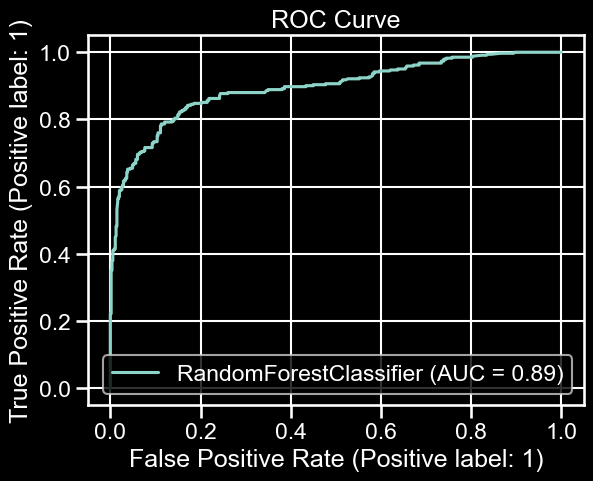

In [827]:
rf_beast.fit(X_train, y_train)
y_pred = rf_beast.predict(X_train)
y_proba = rf_beast.predict_proba(X_train)[:, 1]

print(classification_report(y_train, y_pred))

roc_auc = roc_auc_score(y_train, y_proba)
print(f"ROC AUC: {roc_auc:.4f}")

RocCurveDisplay.from_estimator(rf_beast, X_train, y_train)
plt.title("ROC Curve")
plt.grid(True)
plt.show()

In [829]:
thr = 0.001

low_imp_cols = perm_imp[perm_imp < thr].index.tolist()
print("Будем дропать:", low_imp_cols)


Будем дропать: ['Fare', 'Parch', 'FareBand', 'Is_alone', 'SibSp', 'Embarked_S', 'Embarked_Q', 'Title_Officer', 'Title_Profession', 'Title_Royalty', 'Title_Mrs', 'Title_Miss']


In [830]:
X_train_sel = X_train.drop(columns=low_imp_cols)
X_test_sel  = X_test.drop(columns=low_imp_cols)

In [831]:
def objective(trial):
    params = {
        "n_estimators":     trial.suggest_int( "n_estimators",     500, 5000, step=100),
        "max_depth":        trial.suggest_int( "max_depth",        3,   10),           
        "min_samples_split":trial.suggest_int( "min_samples_split",2,   10),
        "min_samples_leaf": trial.suggest_int( "min_samples_leaf", 1,   10),
        "max_features":     trial.suggest_categorical("max_features",
                                 ["sqrt", "log2", None, 0.5, 0.8]),
        "bootstrap":        trial.suggest_categorical("bootstrap", [True, False]),
        "random_state":     42,
        "n_jobs":           -1
    }

    rf = RandomForestClassifier(**params)
    score = cross_val_score(rf,
                            X_train_sel, y_train,              # ← ваши данные
                            cv=cv,
                            groups=groups,           # билеты
                            scoring="accuracy",
                            n_jobs=-1).mean()
    return score
4
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Лучший результат CV:", round(study.best_value, 4))
print("Параметры:", study.best_params)


[I 2025-05-30 19:33:07,350] A new study created in memory with name: no-name-34d6bdc4-a94a-43b0-9767-b57d1c3da3a2


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-30 19:33:08,969] Trial 0 finished with value: 0.8261194029850746 and parameters: {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 0.8261194029850746.
[I 2025-05-30 19:33:14,475] Trial 1 finished with value: 0.8223880597014925 and parameters: {'n_estimators': 4500, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 10, 'max_features': 0.8, 'bootstrap': False}. Best is trial 0 with value: 0.8261194029850746.
[I 2025-05-30 19:33:18,402] Trial 2 finished with value: 0.8253731343283581 and parameters: {'n_estimators': 2800, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.8261194029850746.
[I 2025-05-30 19:33:25,316] Trial 3 finished with value: 0.8246268656716417 and parameters: {'n_estimators': 4700, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features':

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       549
           1       0.83      0.72      0.77       342

    accuracy                           0.84       891
   macro avg       0.83      0.81      0.82       891
weighted avg       0.83      0.84      0.83       891

ROC AUC: 0.8960


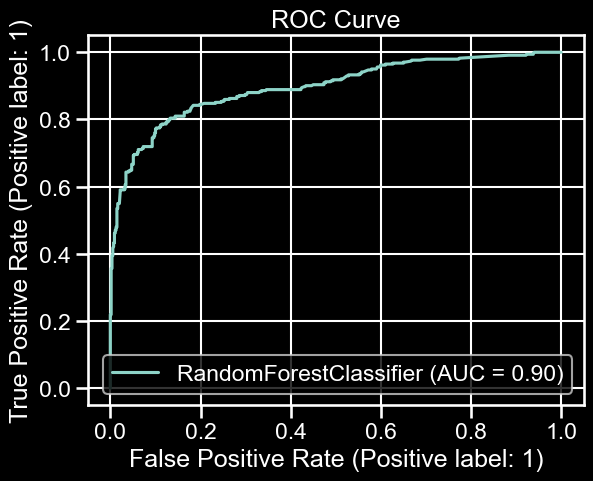

In [834]:
rf_beast.fit(X_train_sel, y_train)
y_pred = rf_beast.predict(X_train_sel)
y_proba = rf_beast.predict_proba(X_train_sel)[:, 1]

print(classification_report(y_train, y_pred))

roc_auc = roc_auc_score(y_train, y_proba)
print(f"ROC AUC: {roc_auc:.4f}")

RocCurveDisplay.from_estimator(rf_beast, X_train_sel, y_train)
plt.title("ROC Curve")
plt.grid(True)
plt.show()

In [836]:
submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived":   rf_beast.predict(X_test_sel)  
})

submission.to_csv("submission.csv", index=False)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Title_Mr


In [289]:
# scaler_robust = RobustScaler()
# scaler_std = StandardScaler()
# scaler_ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')

# train_df['Fare'] = scaler_robust.fit_transform(train_df[['Fare']])
# train_df['Age'] = scaler_std.fit_transform(train_df[['Age']])
# test_df['Fare'] = scaler_robust.transform(test_df[['Fare']])
# test_df['Age'] = scaler_std.transform(test_df[['Age']])


# cat_cols = ['Cabin', 'Embarked', 'Title']


# encoded_train = scaler_ohe.fit_transform(train_df[cat_cols])
# encoded_test = scaler_ohe.transform(test_df[cat_cols])


# encoded_train_df = pd.DataFrame(encoded_train, columns=scaler_ohe.get_feature_names_out(cat_cols), index=train_df.index)
# encoded_test_df = pd.DataFrame(encoded_test, columns=scaler_ohe.get_feature_names_out(cat_cols), index=test_df.index)

# train_df = pd.concat([train_df.drop(columns=cat_cols), encoded_train_df], axis=1)
# test_df = pd.concat([test_df.drop(columns=cat_cols), encoded_test_df], axis=1)
